# ECG abnormality detector

## Authors
Sini Lähde <br>
Omar Nasri <br>
Juuso Torikka

### Objective

Objective of this notebook is to demonstrate arrhythmia 
detection from ECG signals. <br>
This notebook contains all relevant functions 
and functionalities for this project.

In [130]:
# imports
import os

import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import fftpack
import biosppy.signals.ecg as ecg
import numpy as np

In [131]:
DATA_DIRECTORY = "data_sources"
NORMAL_DATA = "normal"
ABNORMAL_DATA = "abnormal"

In [180]:
def get_file_contents(file_path: str, classification: str) -> pd.DataFrame:
    """Process data file contents.

    Reads data from a specific .csv file and extracts the value column.
    The function splits filename to Subject ID part and and event number.
    These values are added to the dataframe along with classification label.

    Parameters
    ----------
    file_path : str
        Full file path to processed file.
    classification : str
        Classification label of the file.

    Returns
    -------
    pd.DataFrame
        Modified Pandas DataFrame

    """

    file_name = os.path.basename(file_path)
    subject_id, event_number = file_name.replace(".csv", "").split("_")[1:]
    subject_id = subject_id.replace("ID", "")

    data = pd.read_csv(file_path)

    data["event_number"] = event_number
    data["subject_id"] = subject_id
    if classification == NORMAL_DATA:
        data["label"] = 0
        return data
    data["label"] = 1
    return data


def get_directory_contents(directory: str, classification: str) -> pd.DataFrame:
    """Process all files in a directory.

    Iterates over all files in given directory. These files are passed to
    get_file_contents() function, which processes each file. Function combines
    all processed files into one Pandas DataFrame.

    Parameters
    ----------
    directory : str
        Root directory of the source data.
    classification : str
        Subdirectory in root, which indicates to correct classification.

    Returns
    -------
    pd.DataFrame
        Concatenated Pandas DataFrame of all files in same directory.

    """
    full_dataset = []
    directory = os.path.join(directory, classification)
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        data = get_file_contents(file_path=file_path, classification=classification)
        data.shape
        full_dataset.append(data)

    return pd.concat(full_dataset, ignore_index=True)


def combine_all_data() -> pd.DataFrame:
    """Combine all data into one DataFrame

    Functions calls processing tasks to get all the data together
    from their respective directories. Combines all these together.

    Returns
    -------
    pd.DataFrame
        Combined Normal and Abnormal data.

    """

    normal_data = get_directory_contents(DATA_DIRECTORY, NORMAL_DATA)
    print("Normal data has been processed\n")
    abnormal_data = get_directory_contents(DATA_DIRECTORY, ABNORMAL_DATA)
    print("Abnormal data has been processed\n")

    df = pd.concat([normal_data, abnormal_data], ignore_index=True)
    return df.sort_values(['subject_id', 'event_number'])

In [181]:
df = combine_all_data()

Normal data has been processed

Abnormal data has been processed



In [184]:
display(df.head())
display(len(df))

,Lead II,event_number,subject_id,label
12625200,-0.390,0,100,0
12625201,-0.395,0,100,0
12625202,-0.390,0,100,0
12625203,-0.405,0,100,0
12625204,-0.405,0,100,0


28443600

In [135]:
# Create a bandpass filter for signal filtering
def bandpass_filter(data, Fs):
    b, a = sp.signal.butter(4, [0.5, 40], btype="bandpass", fs=Fs)
    w, h = sp.signal.freqz(b, a, fs=Fs)
    return sp.signal.filtfilt(b, a, data)

In [192]:
def apply_z_score(data):
    return sp.stats.zscore(data)
    return df


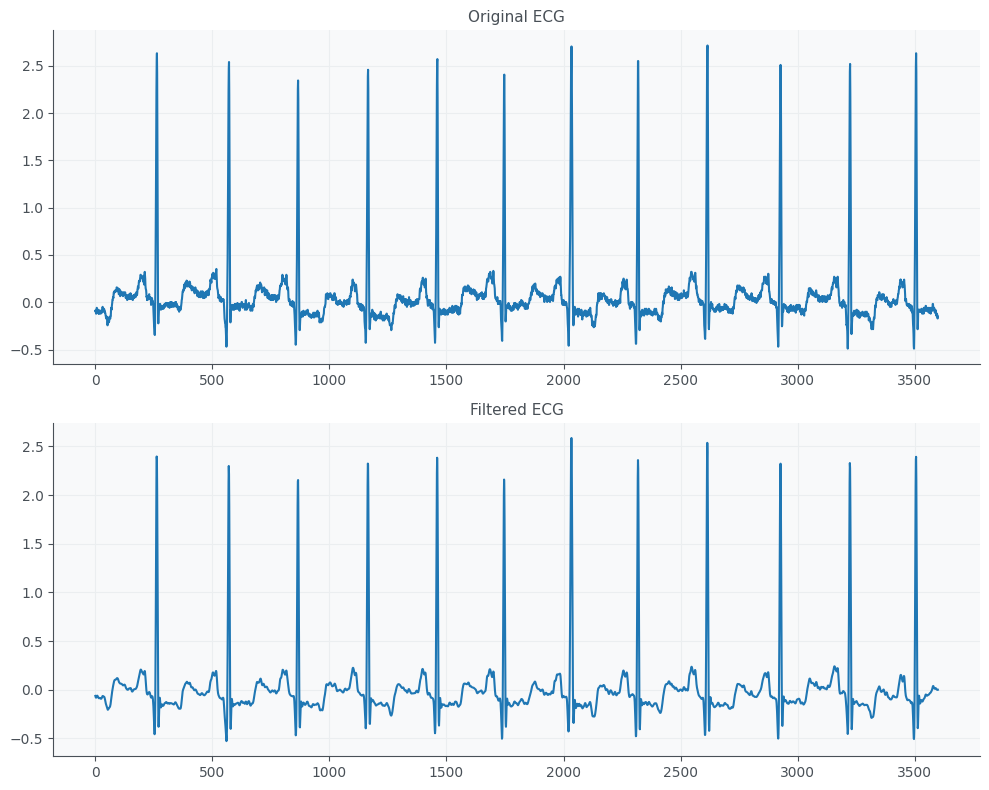

In [188]:
Fs = 360

# Test ecg signal
test_ecg = df["ecg_normalized"].values[: 10 * Fs]

# Apply the filter to the ECG test signal
filtered_ecg = bandpass_filter(test_ecg, Fs)


fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(test_ecg)
ax[0].set_title("Original ECG")
ax[1].plot(filtered_ecg)
ax[1].set_title("Filtered ECG")
plt.tight_layout()

In [193]:
# Create a dataframe for feature extraction
df_features = pd.DataFrame(
    columns=[
        "subject_id",
        "event_number",
        "label",
        "ecg_normalized",
        "qrs_duration",
        "qrs_amplitude",
        "ST_duration",
        "T_duration",
        "T_amplitude",
        "RR_interval",
    ]
)


# Function for calculating QRS durations
def calculate_qrs_durations(ecg: np.ndarray, rpeaks: np.ndarray, Fs: int) -> float:
    """Calculate mean duration of QRS in given signal

    Parameters
    ----------
    ecg : np.ndarray
        ECG signal.
    rpeaks : np.ndarray
        R-Peaks.
    Fs : int
        Frequency

    Returns
    -------
    float
        Mean duration of QRS complex.
    """
    filtered_qrs_durations = []
    derivative = np.gradient(ecg)
    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        # Find the zero crossing before the R peak
        j = rpeak
        while j > 0:
            if derivative[j] > 0:
                j -= 1
            else:
                break
        # Find the zero crossing after the R peak
        k = rpeak
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break
        filtered_qrs_durations.append((k - j) / Fs)
    return np.mean(filtered_qrs_durations)


# Extract features from ECG signal
def extractFeatures(df: pd.DataFrame, Fs: int) -> pd.DataFrame:
    """Extract features from ECG signal

    Parameters
    ----------
    df : pd.DataFrame
        Signal to be processed
    Fs : int
        Frequency

    Returns
    -------
    pd.Dataframe

    """

    df['ecg_normalized'] = df['Lead II']

    ten_second_sample = Fs * 10

    iterations = int(len(df) / ten_second_sample)
    for i in range(iterations):
        # Extract ECG signal
        ecg_signal = df["ecg_normalized"].values[
            i * (ten_second_sample) : (i + 1) * (ten_second_sample)
        ]
        ecg_signal_filtered = bandpass_filter(ecg_signal, Fs)
        ecg_signal_filtered = apply_z_score(ecg_signal_filtered)
        # Extract R peaks
        rpeaks = ecg.hamilton_segmenter(signal=ecg_signal_filtered, sampling_rate=Fs)[0]
        # Extract mean RR interval
        rr_interval = np.mean(np.diff(rpeaks / Fs))

        # Extract QRS features
        qrs_amplitudes = [ecg_signal_filtered[rpeak] for rpeak in rpeaks]
        qrs_amplitude = np.mean(qrs_amplitudes)
        qrs_duration = calculate_qrs_durations(ecg_signal_filtered, rpeaks, Fs)

        # Extract ST features
        st_duration = 0

        # Extract T features
        t_duration = 0
        t_amplitude = 0

        # Add features to dataframe
        df_features.loc[i] = [
            df["subject_id"][i * (ten_second_sample)],
            df["event_number"][i * (ten_second_sample)],
            df["label"][i * (ten_second_sample)],
            df["ecg_normalized"][i * (ten_second_sample)],
            qrs_duration,
            qrs_amplitude,
            st_duration,
            t_duration,
            t_amplitude,
            rr_interval,
        ]
    return df_features


In [194]:
df_features = extractFeatures(df, Fs)

In [195]:
# show first 5 rows of the dataframe
df_features.head()

,subject_id,event_number,label,ecg_normalized,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval
0,105,102,0,-0.200,0.025231,7.027026,0,0,0,0.819192
1,220,95,0,-0.605,0.024573,6.808983,0,0,0,0.806019
2,115,96,0,-0.660,0.024537,6.935898,0,0,0,0.807828
3,212,27,0,-0.050,0.025427,6.759421,0,0,0,0.793056
4,115,116,0,-0.480,0.024306,6.959680,0,0,0,0.800758


In [196]:
df_features.describe()

,label,ecg_normalized,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval
count,7901.000000,7901.000000,7901.000000,7901.000000,7901.0,7901.0,7901.0,7901.000000
mean,0.512087,-0.345825,0.040659,4.462946,0.0,0.0,0.0,0.839884
std,0.499886,0.488619,0.016300,2.097340,0.0,0.0,0.0,0.194991
min,0.000000,-2.555000,0.002778,-4.653913,0.0,0.0,0.0,0.325479
25%,0.000000,-0.625000,0.029815,3.719772,0.0,0.0,0.0,0.700855
50%,1.000000,-0.305000,0.037393,4.780014,0.0,0.0,0.0,0.817361
75%,1.000000,-0.140000,0.049653,5.751997,0.0,0.0,0.0,0.946389
max,1.000000,2.720000,0.227778,9.587360,0.0,0.0,0.0,2.256944
